**Name**: Anirudh Rao

**Roll No.**: BE21B004



---



In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Ignoring any warnings that arise

import warnings
warnings.filterwarnings("ignore")

First, we download the nursery dataset from the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/76/nursery).

In [3]:
# Installing the UCI ML Repository

!pip install ucimlrepo

In [4]:
# Loading the nursery dataset

from ucimlrepo import fetch_ucirepo

nursery = fetch_ucirepo(id=76)
df = pd.DataFrame(nursery.data.features)     # Features
df["class"] = nursery.data.targets           # Label

In [5]:
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In this case, `class` is the label to be predicted.

# Task 1

We divide the dataset into features `X` and label `y`.

In [6]:
# Defining features and label

X = df.drop("class", axis=1)
y = df["class"]

We then import the necessary metrics and procedures to evaluate model performance.

In [7]:
# Importing metrics and cross-validation procedure

from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import cross_validate

We will test the performance of the following models:

1. Decision tree with categorical features
2. Decision tree with one-hot encoded features
3. Logistic regression with L1-regularization
4. $k$-nearest neighbors

**1. Decision tree with categorical features**

Currently, the features are in the form of strings:

In [8]:
X.head()

,parents,has_nurs,form,children,housing,finance,social,health
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended
1,usual,proper,complete,1,convenient,convenient,nonprob,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority


We use `sklearn`'s `LabelEncoder` class to convert these categorical features into numbers. It should be noted that these numbers have no numerical significance, they are merely symbols/representations for the categorical features.

In [9]:
# Encoding the categorical features as numbers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_X = pd.DataFrame()

for col in X.columns:
    categorical_X[col] = le.fit_transform(X[col])

In [10]:
categorical_X.head()

,parents,has_nurs,form,children,housing,finance,social,health
0,2,3,0,0,0,0,0,2
1,2,3,0,0,0,0,0,1
2,2,3,0,0,0,0,0,0
3,2,3,0,0,0,0,2,2
4,2,3,0,0,0,0,2,1


We then divide the transformed dataset into a train dataset and a test dataset with a 80%-20% split. The train dataset will be used for cross-validation to select the best model hyperparameters.

In [11]:
# Train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(categorical_X, y, test_size=0.2, random_state=5401)

We import `sklearn`'s `DecisionTreeClassifier` class and instantiate a model with default hyperparameters. This is subjected to 3-fold cross-validation and the metrics are reported.

In [12]:
# Importing DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

In [13]:
# Evaluating the baseline validation performance

model1 = DecisionTreeClassifier(random_state=5401)
performance1 = cross_validate(model1, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Baseline validation accuracy:", performance1["test_accuracy"].mean())
print("Baseline validation precision:", performance1["test_precision_macro"].mean())

Baseline validation accuracy: 0.9891975308641975
Baseline validation precision: 0.7814036076904091


Our goal is to use hyperparameter tuning to improve the performance. We can see that the accuracy is already fairly high. However, the precision can be improved. Thus, our target metric for improvement is the precision. We will test different combinations of hyperparameters and see which combination achieves the best cross-validation performance. This can be automated using `sklearn`'s `GridSearchCV`.

In [14]:
# Importing GridSearchCV

from sklearn.model_selection import GridSearchCV

We wish to optimize the model by fine-tuning the following parameters:

1. `max_depth`: This is the height of the decision tree. The default value is `None` and the algorithm allows the tree to grow to the required depth. We will test different depths in the range 1 (a stump) to 25.
2. `min_samples_split`: This is the minimum number of samples that must be present in a node in order to split it further. The default value is 2. We will test for higher values - 3, 4, 5.
3. `max_leaf_nodes`: This is the maximum number of leaf nodes that are allowed to be present in the tree. The default value is `None`. Assuming the tree will be balanced, we will test different leaf node numbers from $2^0, 2^1,...,2^{10}$.
4. `criterion`: This is the criterion used to decide the best split. The default is `gini`. We will test `entropy` and `log_loss` as well.

In [15]:
# Defining the hyperparameters to be fine-tuned

decision_tree_param_grid = {"max_depth":list(range(1,25))+[None],
                            "min_samples_split":[2,3,4,5],
                            "max_leaf_nodes":[2**i for i in range(1,10)]+[None],
                            "criterion":["gini","entropy","log_loss"]}

In [16]:
# Running GridSearchCV with 3-fold cross-validation

grid_model1 = GridSearchCV(model1, decision_tree_param_grid, cv=3, scoring="precision_macro",verbose=1)
grid_model1.fit(X_train, y_train)

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=5401),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, None],
                         'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128, 256, 512,
                                            None],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='precision_macro', verbose=1)

In [17]:
# Obtaining the best hyperparameters

grid_model1.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_leaf_nodes': 256,
 'min_samples_split': 2}

We can see that the "discovered" hyperparameters for `max_depth` and `max_leaf_nodes` are different from the default. Let us check the cross-validation performance of the optimized model.

In [18]:
# Evaluating the improved validation performance

best_performance1 = cross_validate(grid_model1.best_estimator_, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Validation accuracy:", best_performance1["test_accuracy"].mean())
print("Validation precision:", best_performance1["test_precision_macro"].mean())

Validation accuracy: 0.9833140432098766
Validation precision: 0.8390314633277068


Although the accuracy has reduced by 0.006, the precision has increased by 0.06. We can now test the improved model on the test set. To understand its performance for different random instantiations, we conduct 5 iterations of training and testing. This gives us the mean and standard deviation of its test performance.

In [19]:
# Evaluating the average test performance

np.random.seed(5401)

model1_accuracies = []
model1_precisions = []

for i in range(5):
    best_model1 = DecisionTreeClassifier(**grid_model1.best_params_)
    best_model1.fit(X_train, y_train)
    y_pred1 = best_model1.predict(X_test)
    model1_accuracies.append(accuracy_score(y_test, y_pred1))
    model1_precisions.append(precision_score(y_test, y_pred1, average="macro"))

print(f"Test accuracy: {np.mean(model1_accuracies)} ± {np.std(model1_accuracies)}")
print(f"Test precision: {np.mean(model1_precisions)} ± {np.std(model1_precisions)}")

Test accuracy: 0.9885802469135803 ± 0.0001890038381777016
Test precision: 0.8521414654271455 ± 0.09505711793829567


We can see that the accuracy and precision on the test set are high. The precision is much better than the baseline model.

**2. Decision tree with one-hot encoded features**

An alternative approach to encode the categorical features is to use one-hot encoding. We will test if the model's performance improves when this approach is used.

In [20]:
X.head()

,parents,has_nurs,form,children,housing,finance,social,health
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended
1,usual,proper,complete,1,convenient,convenient,nonprob,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority


In [21]:
# Implementing one-hot encoding

one_hot_encoded_X = pd.get_dummies(X)

In [22]:
one_hot_encoded_X.head()

,parents_great_pret,parents_pretentious,parents_usual,has_nurs_critical,has_nurs_improper,has_nurs_less_proper,has_nurs_proper,has_nurs_very_crit,form_complete,form_completed,...,housing_critical,housing_less_conv,finance_convenient,finance_inconv,social_nonprob,social_problematic,social_slightly_prob,health_not_recom,health_priority,health_recommended
0,False,False,True,False,False,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True
1,False,False,True,False,False,False,True,False,True,False,...,False,False,True,False,True,False,False,False,True,False
2,False,False,True,False,False,False,True,False,True,False,...,False,False,True,False,True,False,False,True,False,False
3,False,False,True,False,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
4,False,False,True,False,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,True,False


We can evaluate the cross-validation performance of the `DecisionTreeClassifier` on this transformed data.

In [23]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_X, y, test_size=0.2, random_state=5401)

In [24]:
# Evaluating the baseline validation performance

model2 = DecisionTreeClassifier(random_state=5401)
performance2 = cross_validate(model2, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Baseline validation accuracy:", performance2["test_accuracy"].mean())
print("Baseline validation precision:", performance2["test_precision_macro"].mean())

Baseline validation accuracy: 0.9915123456790124
Baseline validation precision: 0.9001928978524996


Both the baseline accuracy and precision are higher than when directly encoded data was used. Thus, one-hot encoding seems to be a good strategy. We can now fine-tune the hyperparameters of the model.

In [25]:
# Running GridSearchCV with 3-fold cross-validation

grid_model2 = GridSearchCV(model2, decision_tree_param_grid, cv=3, scoring="precision_macro",verbose=1)
grid_model2.fit(X_train, y_train)

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=5401),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, None],
                         'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128, 256, 512,
                                            None],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='precision_macro', verbose=1)

In [26]:
# Obtaining the best hyperparameters

grid_model2.best_params_

{'criterion': 'gini',
 'max_depth': 14,
 'max_leaf_nodes': None,
 'min_samples_split': 3}

The optimized hyperparameters for `max_depth` and `min_samples_split` are different from the default.

In [27]:
# Evaluating the improved validation performance

best_performance2 = cross_validate(grid_model2.best_estimator_, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Validation accuracy:", best_performance2["test_accuracy"].mean())
print("Validation precision:", best_performance2["test_precision_macro"].mean())

Validation accuracy: 0.9912229938271605
Validation precision: 0.9020106781256678


There is only a moderate increase in performance.

In [28]:
# Evaluating the average test performance

np.random.seed(5401)

model2_accuracies = []
model2_precisions = []

for i in range(5):
    best_model2 = DecisionTreeClassifier(**grid_model2.best_params_)
    best_model2.fit(X_train, y_train)
    y_pred2 = best_model2.predict(X_test)
    model2_accuracies.append(accuracy_score(y_test, y_pred2))
    model2_precisions.append(precision_score(y_test, y_pred2, average="macro"))

print(f"Test accuracy: {np.mean(model2_accuracies)} ± {np.std(model2_accuracies)}")
print(f"Test precision: {np.mean(model2_precisions)} ± {np.std(model2_precisions)}")

Test accuracy: 0.9954475308641977 ± 0.0006172839506172866
Test precision: 0.989121789811405 ± 0.000483551407722782


We can see that the accuracy and precision on the test set are quite high.

**3. Logistic regression with L1 regularization**

We will use the one-hot encoded data to train a logistic regression model that is subjected to L1 regularization.

In [29]:
# Importing LogisticRegression

from sklearn.linear_model import LogisticRegression

In [30]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_X, y, test_size=0.2, random_state=5401)

In [31]:
# Evaluating the baseline validation performance

model3 = LogisticRegression(penalty="l1", solver="liblinear")
performance3 = cross_validate(model3, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Baseline validation accuracy:", performance3["test_accuracy"].mean())
print("Baseline validation precision:", performance3["test_precision_macro"].mean())

Baseline validation accuracy: 0.9139660493827161
Baseline validation precision: 0.5943107536319653


The precision in this case is quite poor compared to the `DecisionTreeClassifer` models. We will fine-tune the regularization parameter for this model in hopes of improving performance. The default value is $1$. Smaller values lead to higher regularization.

In [32]:
# Defining the hyperparameter to be fine-tuned

logistic_regression_param_grid = {"C":np.linspace(0,1,100)}

In [33]:
# Running GridSearchCV with 3-fold cross-validation

grid_model3 = GridSearchCV(model3, logistic_regression_param_grid, cv=3, scoring="precision_macro",verbose=1)
grid_model3.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23...
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ])},
             scoring='precision_macro', verbose=1)

In [34]:
# Obtaining the best hyperparameter

grid_model3.best_params_

{'C': 0.08080808080808081}

The strength of the regularization is higher than the default.

In [35]:
# Evaluating the improved validation performance

best_performance3 = cross_validate(grid_model3.best_estimator_, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Validation accuracy:", best_performance3["test_accuracy"].mean())
print("Validation precision:", best_performance3["test_precision_macro"].mean())

Validation accuracy: 0.9157986111111112
Validation precision: 0.5955419879006841


There is only marginal improvement in the performance.

In [36]:
# Evaluating the average test performance

model3_accuracies = []
model3_precisions = []

for i in range(5):
    best_model3 = LogisticRegression(penalty="l1", solver="liblinear", **grid_model3.best_params_)
    best_model3.fit(X_train, y_train)
    y_pred3 = best_model3.predict(X_test)
    model3_accuracies.append(accuracy_score(y_test, y_pred3))
    model3_precisions.append(precision_score(y_test, y_pred3, average="macro"))

print(f"Test accuracy: {np.mean(model3_accuracies)} ± {np.std(model3_accuracies)}")
print(f"Test precision: {np.mean(model3_precisions)} ± {np.std(model3_precisions)}")

Test accuracy: 0.9182098765432098 ± 0.0
Test precision: 0.6891480696421906 ± 0.0


The test precision is higher than the validation precision. However, this is still worse than the `DecisionTreeClassifier`. There is no variance in the performance as `LogisticRegression` is a deterministic model, unlike the `DecisionTreeClassifier`.

**$k$-nearest neighbors**

We also test the performance of the `KNeighborsClassifier` on the one-hot encoded data.

In [37]:
# Importing KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier

In [38]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_X, y, test_size=0.2, random_state=5401)

In [39]:
# Evaluating the baseline validation performance

model4 = KNeighborsClassifier()
performance4 = cross_validate(model4, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Baseline validation accuracy:", performance4["test_accuracy"].mean())
print("Baseline validation precision:", performance4["test_precision_macro"].mean())

Baseline validation accuracy: 0.9288194444444445
Baseline validation precision: 0.8067285768776831


The baseline performance is better than `LogisticRegression` but not as good as `DecisionTreeClassifier`. We can fine-tune the number of neighbors being used by the algorithm. The default value is 5. We try different number of neighbors up to 100.

In [40]:
# Defining the hyperparameter to be fine-tuned

knn_param_grid = {"n_neighbors":[int(x) for x in np.linspace(0,100,101)]}

In [41]:
# Running GridSearchCV with 3-fold cross-validation

grid_model4 = GridSearchCV(model4, knn_param_grid, cv=3, scoring="precision_macro",verbose=1)
grid_model4.fit(X_train, y_train)

Fitting 3 folds for each of 101 candidates, totalling 303 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                         12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                                         22, 23, 24, 25, 26, 27, 28, 29, ...]},
             scoring='precision_macro', verbose=1)

In [42]:
# Obtaining the best hyperparameter

grid_model4.best_params_

{'n_neighbors': 11}

Using 11 neighbors seems to achieve the best performance. This is different from the default value of 5.

In [43]:
# Evaluating the improved validation performance

best_performance4 = cross_validate(grid_model4.best_estimator_, X_train, y_train, cv=3, scoring=["accuracy","precision_macro"])

print("Validation accuracy:", best_performance4["test_accuracy"].mean())
print("Validation precision:", best_performance4["test_precision_macro"].mean())

Validation accuracy: 0.9556327160493828
Validation precision: 0.8362386377976203


There is some improvement from the baseline performance.

In [44]:
# Evaluating the average test performance

model4_accuracies = []
model4_precisions = []

for i in range(5):
    best_model4 = KNeighborsClassifier(**grid_model4.best_params_)
    best_model4.fit(X_train, y_train)
    y_pred4 = best_model4.predict(X_test)
    model4_accuracies.append(accuracy_score(y_test, y_pred4))
    model4_precisions.append(precision_score(y_test, y_pred4, average="macro"))

print(f"Test accuracy: {np.mean(model4_accuracies)} ± {np.std(model4_accuracies)}")
print(f"Test precision: {np.mean(model4_precisions)} ± {np.std(model4_precisions)}")

Test accuracy: 0.9645061728395061 ± 0.0
Test precision: 0.9738101738351427 ± 0.0


The performance on the test set is quite good. Again, there is no variance is this is a deterministic model.

**Visualizing the metrics**

We can visualize the test performance metrics of these new models and compare them with the baseline performance metrics given in the UCI Repository.

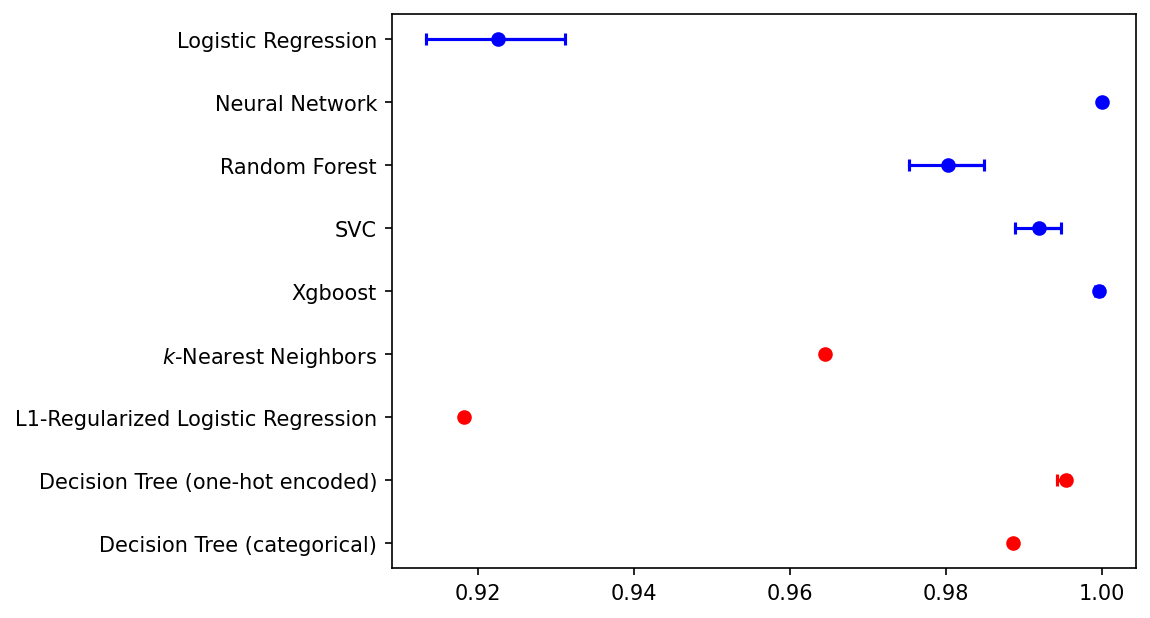

In [45]:
# Visualizing the model's accuracies

plt.figure(dpi=150)

new_accuracies_mean = {"Decision Tree (categorical)": np.mean(model1_accuracies),
                       "Decision Tree (one-hot encoded)": np.mean(model2_accuracies),
                       "L1-Regularized Logistic Regression": np.mean(model3_accuracies),
                       "$k$-Nearest Neighbors": np.mean(model4_accuracies)}
new_accuracies_high = {"Decision Tree (categorical)": max(model1_accuracies),
                       "Decision Tree (one-hot encoded)": max(model2_accuracies),
                       "L1-Regularized Logistic Regression": max(model3_accuracies),
                       "$k$-Nearest Neighbors": max(model4_accuracies)}
new_accuracies_low = {"Decision Tree (categorical)": min(model1_accuracies),
                      "Decision Tree (one-hot encoded)": min(model2_accuracies),
                      "L1-Regularized Logistic Regression": min(model3_accuracies),
                      "$k$-Nearest Neighbors": min(model4_accuracies)}

plt.scatter(new_accuracies_mean.values(), new_accuracies_mean.keys(), c="r")
plt.scatter(new_accuracies_high.values(), new_accuracies_high.keys(), c="r", marker="|")
plt.scatter(new_accuracies_low.values(), new_accuracies_low.keys(), c="r", marker="|")

for model in new_accuracies_mean.keys():
    values = [new_accuracies_mean[model], new_accuracies_high[model], new_accuracies_low[model]]
    plt.plot(values, [model] * 3, c="r")

existing_baseline_accuracies_mean = {"Xgboost": 0.99969, "SVC": 0.99198, "Random Forest": 0.98025,
                                     "Neural Network": 1.00, "Logistic Regression": 0.92253}
existing_baseline_accuracies_high = {"Xgboost": 1.00, "SVC": 0.99475, "Random Forest": 0.98488, "Neural Network": 1.00,
                                     "Logistic Regression": 0.93117}
existing_baseline_accuracies_low = {"Xgboost": 0.99907, "SVC": 0.98889, "Random Forest": 0.97531,
                                    "Neural Network": 1.00, "Logistic Regression": 0.91327}

plt.scatter(existing_baseline_accuracies_mean.values(), existing_baseline_accuracies_mean.keys(), c="b")
plt.scatter(existing_baseline_accuracies_high.values(), existing_baseline_accuracies_high.keys(), c="b", marker="|")
plt.scatter(existing_baseline_accuracies_low.values(), existing_baseline_accuracies_low.keys(), c="b", marker="|")

for model in existing_baseline_accuracies_mean.keys():
    values = [existing_baseline_accuracies_mean[model], existing_baseline_accuracies_high[model],
              existing_baseline_accuracies_low[model]]
    plt.plot(values, [model] * 3, c="b")

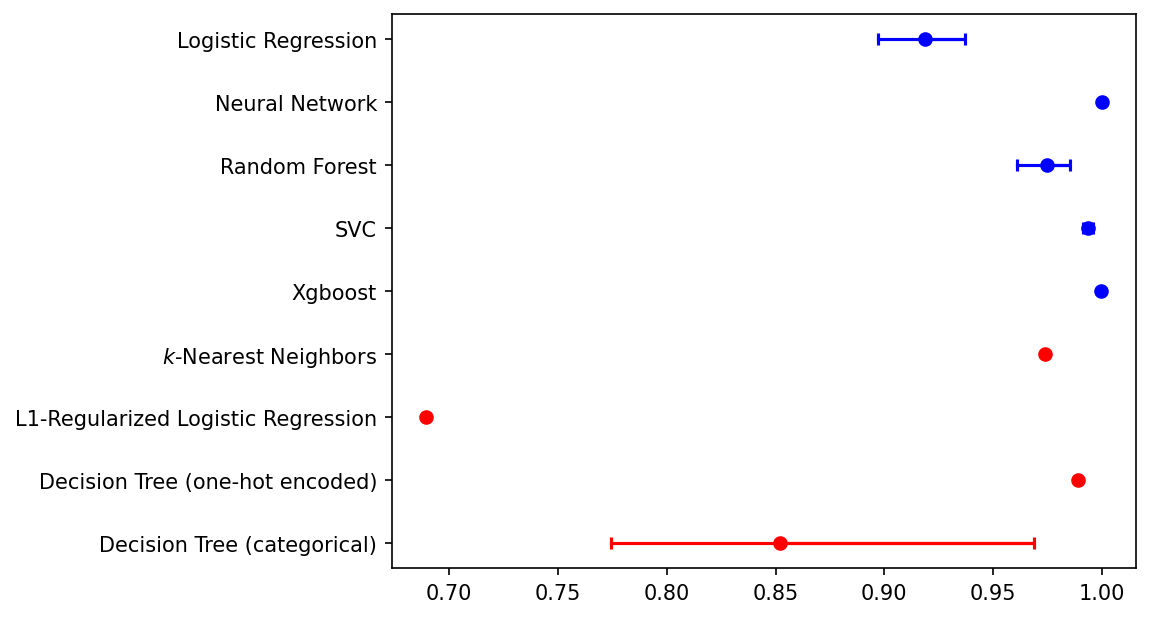

In [46]:
# Visualizing the model's precisions

plt.figure(dpi=150)

new_precisions_mean = {"Decision Tree (categorical)": np.mean(model1_precisions),
                       "Decision Tree (one-hot encoded)": np.mean(model2_precisions),
                       "L1-Regularized Logistic Regression": np.mean(model3_precisions),
                       "$k$-Nearest Neighbors": np.mean(model4_precisions)}
new_precisions_high = {"Decision Tree (categorical)": max(model1_precisions),
                       "Decision Tree (one-hot encoded)": max(model2_precisions),
                       "L1-Regularized Logistic Regression": max(model3_precisions),
                       "$k$-Nearest Neighbors": max(model4_precisions)}
new_precisions_low = {"Decision Tree (categorical)": min(model1_precisions),
                      "Decision Tree (one-hot encoded)": min(model2_precisions),
                      "L1-Regularized Logistic Regression": min(model3_precisions),
                      "$k$-Nearest Neighbors": min(model4_precisions)}

plt.scatter(new_precisions_mean.values(), new_precisions_mean.keys(), c="r")
plt.scatter(new_precisions_high.values(), new_precisions_high.keys(), c="r", marker="|")
plt.scatter(new_precisions_low.values(), new_precisions_low.keys(), c="r", marker="|")

for model in new_precisions_mean.keys():
    values = [new_precisions_mean[model], new_precisions_high[model], new_precisions_low[model]]
    plt.plot(values, [model] * 3, c="r")

existing_baseline_precisions_mean = {"Xgboost": 0.99976, "SVC": 0.99367, "Random Forest": 0.97473,
                                     "Neural Network": 1.00, "Logistic Regression": 0.91868}
existing_baseline_precisions_high = {"Xgboost": 1.00, "SVC": 0.99595, "Random Forest": 0.98547, "Neural Network": 1.00,
                                     "Logistic Regression": 0.93710}
existing_baseline_precisions_low = {"Xgboost": 0.99926, "SVC": 0.99120, "Random Forest": 0.96113,
                                    "Neural Network": 1.00, "Logistic Regression": 0.89713}

plt.scatter(existing_baseline_precisions_mean.values(), existing_baseline_precisions_mean.keys(), c="b")
plt.scatter(existing_baseline_precisions_high.values(), existing_baseline_precisions_high.keys(), c="b", marker="|")
plt.scatter(existing_baseline_precisions_low.values(), existing_baseline_precisions_low.keys(), c="b", marker="|")

for model in existing_baseline_precisions_mean.keys():
    values = [existing_baseline_precisions_mean[model], existing_baseline_precisions_high[model],
              existing_baseline_precisions_low[model]]
    plt.plot(values, [model] * 3, c="b")

The new models do not achieve performance as high as the existing baselines. However, they come quite close to it, especially the `DecisionTreeClassifer` trained on one-hot encoded data. `LogisticRegression` with L1-regularization has the worst performance.

# Task 2

**1.**

The unipolar sigmoid is given by $\frac{1}{1+e^{-x}}$ which has the range $[0,1]$. Multiplying this by $2$ will change the range to $[0,2]$. Subtracting $1$ from this will bring the range to $[-1,1]$. Thus, the bipolar sigmoid is given by $\frac{2}{1+e^{-x}}-1 = 2($UnipolarSigmoid$) - 1$.

In [47]:
# Defining the unipolar sigmoid

def unipolar_sigmoid(x,a=1):
    return 1/(1+np.exp(-a*x))

In [48]:
# Defining the bipolar sigmoid in terms of the unipolar sigmoid

def bipolar_sigmoid(x,a=1):
    return 2*unipolar_sigmoid(a*x)-1

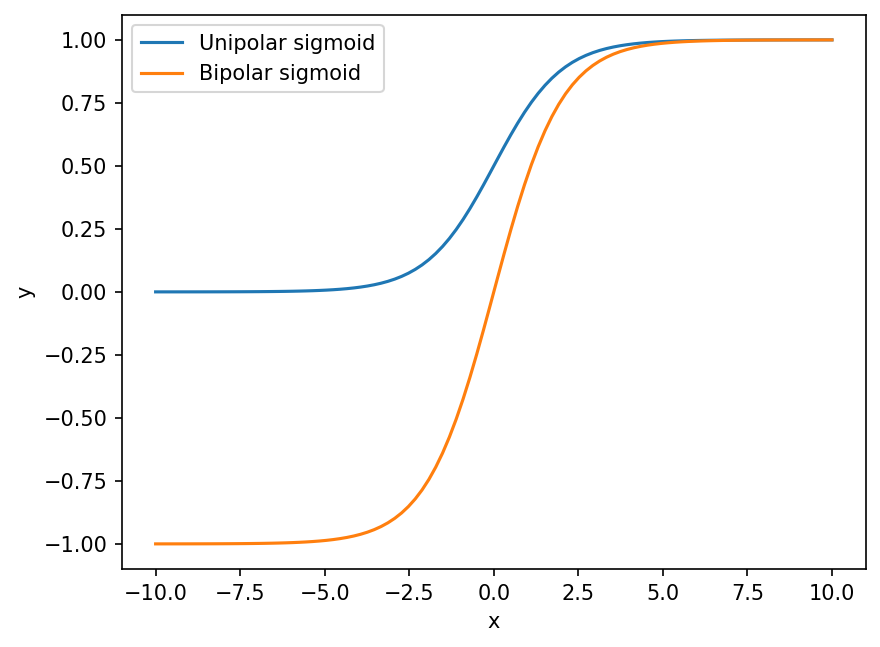

In [49]:
# Visualizing the two sigmoid curves

x = np.linspace(-10,10,100)

plt.figure(dpi=150)
plt.plot(x,unipolar_sigmoid(x),label="Unipolar sigmoid")
plt.plot(x,bipolar_sigmoid(x),label="Bipolar sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

**2.**

We then compare the response of the bipolar sigmoid with the hypertangent function.

In [50]:
# Defining the tanh function

def tanh(x,a=1):
    return np.tanh(a*x)

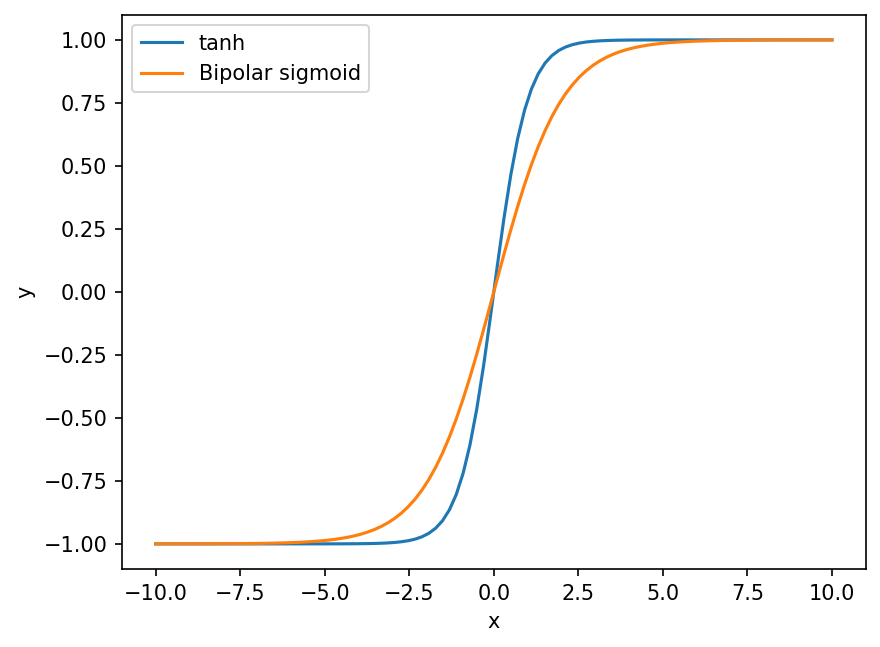

In [51]:
# Visualizing the responses of the bipolar sigmoid and the tanh function

plt.figure(dpi=150)
plt.plot(x,tanh(x),label="tanh")
plt.plot(x,bipolar_sigmoid(x),label="Bipolar sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Both the functions have similar responses. The tanh function saturates faster than the bipolar sigmoid.

**3.**

We then evaluate the responses of the two functions for different values of the multiplicative factor $a$.

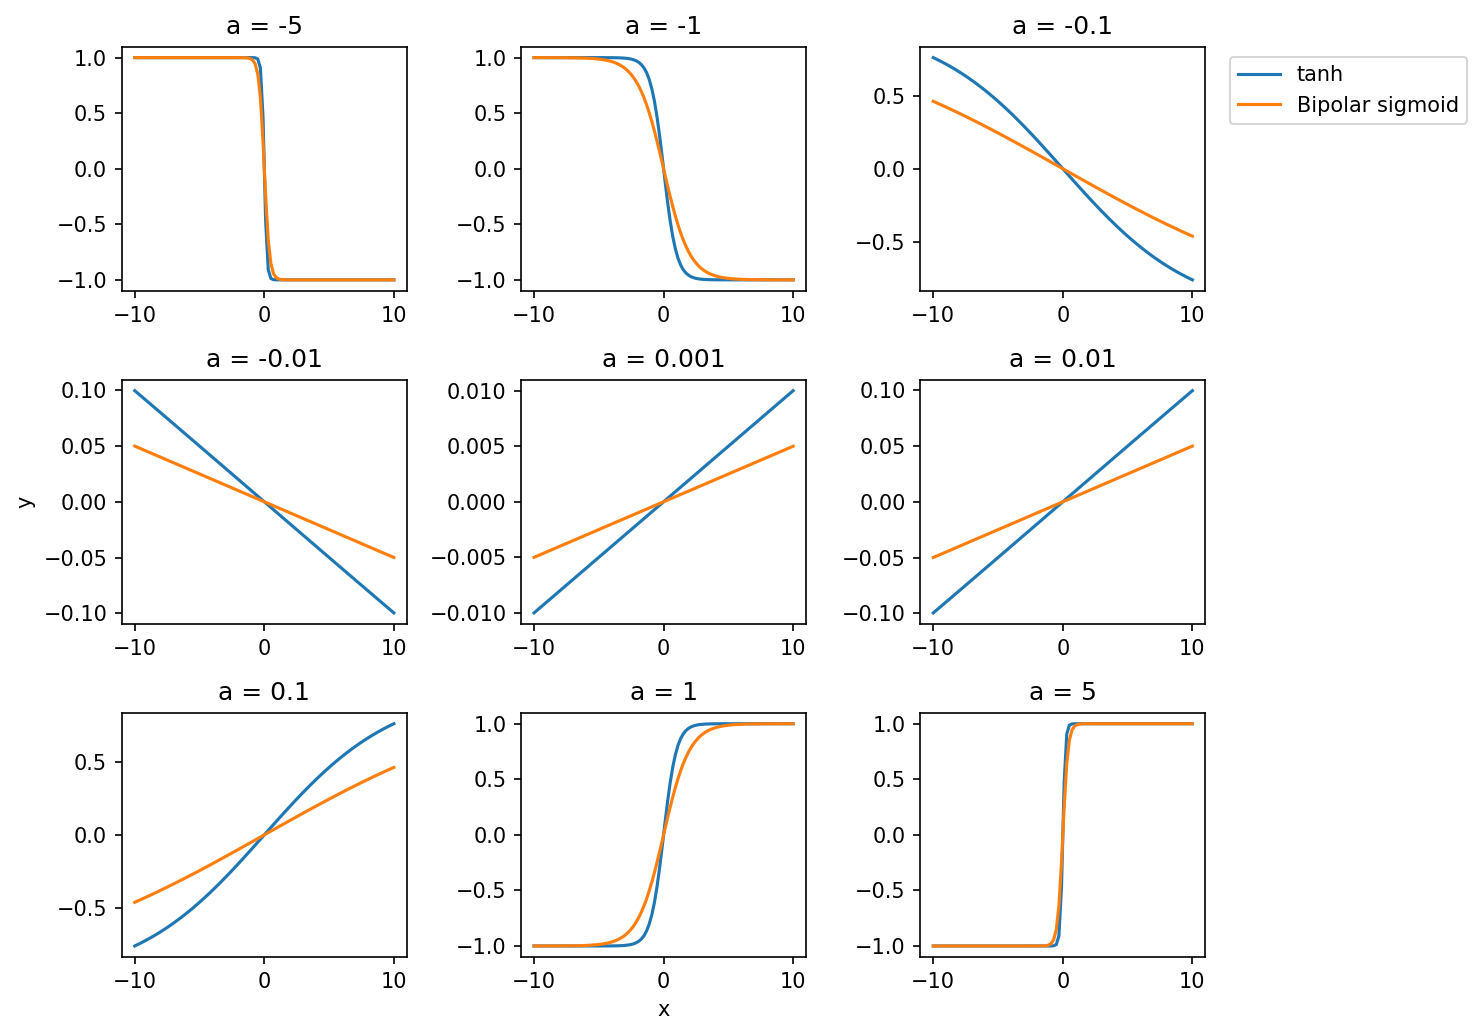

In [52]:
# Visualizing the two functions for different values of a

a = [-5, -1, -0.1, -0.01, 0.001, 0.01, 0.1, 1, 5]

fig, ax = plt.subplots(3, 3, dpi=150, figsize=(10, 7))

for i in range(3):
    for j in range(3):
        ax[i, j].plot(x, tanh(x, a=a[i * 3 + j]), label="tanh")
        ax[i, j].plot(x, bipolar_sigmoid(x, a=a[i * 3 + j]), label="Bipolar sigmoid")
        ax[i, j].set_title(f"a = {a[i * 3 + j]}")

ax[2, 1].set_xlabel("x")
ax[1, 0].set_ylabel("y")
ax[0, 2].legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

We can see that when $|a|$ is small, the functions are highly linear for $x\in[-10,10]$. As $|a|$ increases, the sigmoidal behaviour emerges.

**4.**

To evaluate the range of values of $x$ for which the bipolar sigmoid has a linear response, we find those points at which $f'(x) \approx f'(0)$, within some tolerance. We can do this because the linear range will be symmetric about $x=0$. The first derivative of the bipolar sigmoid can be computed to be $\frac{ae^{-ax}}{(e^{-ax}+1)^2}$ .

In [53]:
# Defining the first derivative of the bipolar sigmoid

def first_derivative(x,a):
    return np.round((a*np.exp(-a*x))/(np.exp(-a*x)+1)**2,4)

In [54]:
# Obtaining the linear range for different values of a based on the strategy described above

linear_ranges = dict()
for a_val in [0.001, 0.01, 0.1, 1, 5]:
    derivative_at_zero = first_derivative(0, a_val)
    tolerance = a_val / 10  # Tolerance for comparing first derivative at x and at 0
    linear_range = 0
    i = -5
    linear_ranges[a_val] = i
    while abs(first_derivative(2 ** i, a_val) - derivative_at_zero) <= tolerance:
        linear_ranges[a_val] = i
        i += 0.5

all_linear_ranges = {a_val: (-2 ** linear_ranges[abs(a_val)], 2 ** linear_ranges[abs(a_val)]) for a_val in a}
ranges = pd.DataFrame(all_linear_ranges).T
ranges.columns = ["Lower bound", "Upper bound"]
ranges

,Lower bound,Upper bound
-5.000,-0.250000,0.250000
-1.000,-1.414214,1.414214
-0.100,-11.313708,11.313708
-0.010,-128.000000,128.000000
0.001,-2048.000000,2048.000000
0.010,-128.000000,128.000000
0.100,-11.313708,11.313708
1.000,-1.414214,1.414214
5.000,-0.250000,0.250000


We can see that as $|a|$ decreases, the linear range increases.

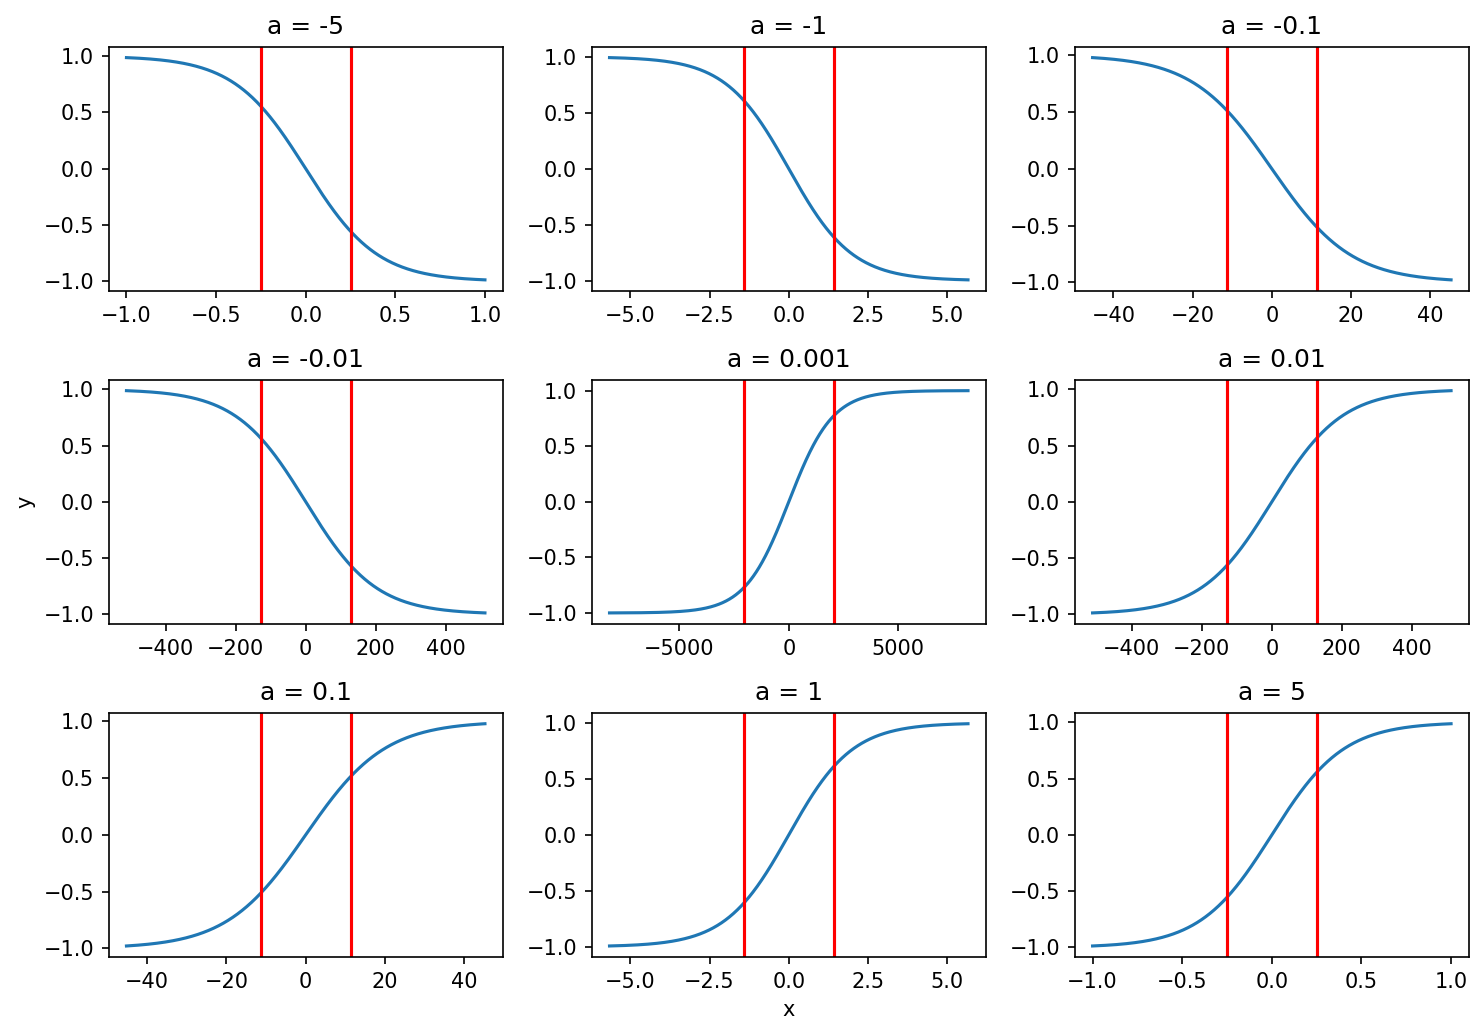

In [55]:
# Visualizing the linear ranges

fig, ax = plt.subplots(3, 3, dpi=150, figsize=(10, 7))

for i in range(3):
    for j in range(3):
        upper_bound = linear_ranges[abs(a[i * 3 + j])]
        x = np.linspace(-2 ** (upper_bound + 2), 2 ** (upper_bound + 2), 1000)
        ax[i, j].plot(x, bipolar_sigmoid(x, a=a[i * 3 + j]))
        ax[i, j].axvline(2 ** upper_bound, c="r")
        ax[i, j].axvline(-2 ** upper_bound, c="r")
        ax[i, j].set_title(f"a = {a[i * 3 + j]}")

ax[2, 1].set_xlabel("x")
ax[1, 0].set_ylabel("y")
plt.tight_layout()
plt.show()



---

